### Python Packages

In [8]:
import re
import time

import biotite.sequence.io.fasta as bioseq
from unipressed import IdMappingClient
import pandas as pd

### 1. Import Sequences

In [9]:
fasta_file = bioseq.FastaFile()
fasta_file.read("sequences/p450_edit2.fasta")
sequences = bioseq.get_sequences(fasta_file)
headers = list(sequences.keys())

In [12]:
# get all file names from folder
import os
files = os.listdir("Alphafold/alphafold_structures/")
# remove the extension
files = [file.split(".")[0] for file in files]

# check for missing files in headers
missing_files = []
for header in headers:
    if header not in files:
        missing_files.append(header)
# check for missing headers in files
missing_headers = []
for file in files:
    if file not in headers:
        missing_headers.append(file)
print(missing_files)
print(missing_headers)

[]
[]


### 2. Isolate Header from Substrate Specificity

In [80]:
def header_breakdown(sequences):
    # Extract headers from sequence keys
    headers = list(sequences.keys())
    
    # Convert headers to DataFrame and split by delimiters ~, -, /
    df = pd.DataFrame(headers, columns=['initial_header'])
    df = df['initial_header'].str.split('~|-|/', expand=True)
    
    # Get unique non-null values from columns 2, 3, 4
    unique_values = pd.unique(df.iloc[:, 2:5].values.ravel())
    unique_values = unique_values[~pd.isna(unique_values)]
    
    # Create new columns based on unique values presence
    for value in unique_values:
        df[value] = df.iloc[:, 2:5].apply(lambda x: value in x.values, axis=1)
    
    # Retain necessary columns and sort them
    df = df.drop(columns=[2, 3, 4])
    df = df[[0, 1] + sorted(unique_values.tolist())]
    
    # Rename columns and set the 'Positive_control' column
    df.columns = ['accession_id', 'Positive_control'] + df.columns[2:].tolist()
    df['Positive_control'] = df['Positive_control'].str.contains('Positive_Control', case=False, na=False)
    
    # Add the original headers back as the first column
    df.insert(0, 'initial_header', headers)

    # Add sequence string to end
    df['Sequence'] = df['initial_header'].map(sequences)
    # convert list of characters to string
    df['Sequence'] = df['Sequence'].apply(lambda x: ''.join(x))
    
    return df

header_df = header_breakdown(sequences)

# Save the DataFrame to a CSV file
header_df.to_csv("sequences/p450_header_breakdown.csv", index=False)

# print
seqs = header_df[["initial_header", "accession_id", "Sequence"]]

### 3. Determine the source of the sequence and if in Uniprot Database

In [81]:
# Import the necessary library
from pathlib import Path

def convert_fasta_to_two_text_files(input_fasta, output_txt1, output_txt2):
    with open(input_fasta, 'r') as fasta_file, open(output_txt1, 'w') as text_file1, open(output_txt2, 'w') as text_file2:
        sequence = []
        file_switch = True  # To alternate between the two files
        for line in fasta_file:
            line = line.strip()
            if line.startswith('>'):
                if sequence:
                    if file_switch:
                        text_file1.write(''.join(sequence) + '\n')
                    else:
                        text_file2.write(''.join(sequence) + '\n')
                    sequence = []
                    file_switch = not file_switch  # Switch between the two files
            else:
                sequence.append(line)
        if sequence:
            if file_switch:
                text_file1.write(''.join(sequence) + '\n')
            else:
                text_file2.write(''.join(sequence) + '\n')

# Define file paths
input_fasta = "sequences/p450_edit.fasta"  # Replace with your input FASTA file path
output_txt1 = 'output1.txt'  # Replace with your first output text file path
output_txt2 = 'output2.txt'  # Replace with your second output text file path

# Call the conversion function
convert_fasta_to_two_text_files(input_fasta, output_txt1, output_txt2)

In [82]:
import pandas as pd

batch1 = pd.read_csv("sequences/uniprot_pepsearch_batch1.tsv", sep='\t')
batch2 = pd.read_csv("sequences/uniprot_pepsearch_batch2.tsv", sep='\t')

# Combine the two batches
combined = pd.concat([batch1, batch2], ignore_index=True)
combined['Reviewed'] = combined['Reviewed'].apply(lambda x: 'reviewed' == x)

seqs = seqs.merge(combined, on='Sequence', how='left')

def remove_duplicates(df):

    # group by sequence
    grouped = combined.groupby('Sequence')

    # filter for sequences with only 1 entry
    single_entry_seqs = grouped.filter(lambda x: len(x) == 1)

    # filter for sequences with more than 1 entry
    multi_entry_seqs = grouped.filter(lambda x: len(x) > 1)

    # Group by sequence and count number of reviewed entried
    grouped = multi_entry_seqs.groupby('Sequence')
    one_reviewed = grouped['Reviewed'].sum()

    single_reviewed = one_reviewed[one_reviewed == 1]
    # filter single_reviwed_seqs for Reviewed == True
    single_reviewed_entries = multi_entry_seqs[multi_entry_seqs['Sequence'].isin(single_reviewed.index)]
    single_reviewed_entries = single_reviewed_entries[single_reviewed_entries['Reviewed']]

    single_entry_seqs = pd.concat([single_entry_seqs, single_reviewed_entries])
    multi_entry_seqs = multi_entry_seqs[~multi_entry_seqs['Sequence'].isin(single_reviewed.index)]

    # do the same for organism ID
    grouped = multi_entry_seqs.groupby('Sequence')
    one_organism = grouped['Organism (ID)'].nunique()

    single_organism = one_organism[one_organism == 1]
    single_organism_entries = multi_entry_seqs[multi_entry_seqs['Sequence'].isin(single_organism.index)]
    single_organism_entries = single_organism_entries[single_organism_entries['Organism (ID)'].notna()]

    single_entry_seqs = pd.concat([single_entry_seqs, single_organism_entries])
    multi_entry_seqs = multi_entry_seqs[~multi_entry_seqs['Sequence'].isin(single_organism.index)]

    # do the same for EMBL
    grouped = multi_entry_seqs.groupby('Sequence')
    one_embl = grouped['EMBL'].nunique()

    single_embl = one_embl[one_embl == 1]
    single_embl_entries = multi_entry_seqs[multi_entry_seqs['Sequence'].isin(single_embl.index)]
    single_embl_entries = single_embl_entries[single_embl_entries['EMBL'].notna()]

    single_entry_seqs = pd.concat([single_entry_seqs, single_embl_entries])
    multi_entry_seqs = multi_entry_seqs[~multi_entry_seqs['Sequence'].isin(single_embl.index)]

    return single_entry_seqs

mapping = remove_duplicates(combined)



In [83]:
import requests
import time

# Define the endpoint and the data
url = "https://peptidesearch.uniprot.org/asyncrest/"
data = {
    'peps': 'AAVEEGIVLGGGCALLR,STKKSVQY',  # Comma-separated peptides
    'taxIds': '9606,10090',                # Comma-separated taxIds
    'lEQi': 'on',                          # Treat Leucine and Isoleucine as equivalent
    'spOnly': 'on'                         # Search UniProt Reviewed (Swiss-Prot) only
}

# Send the POST request
response = requests.post(url, data=data)

# Check if the request was accepted
if response.status_code == 202:
    job_location = response.headers['Location']
    print(f"Job accepted, check status at: {job_location}")
else:
    print(f"Error: {response.status_code}")


# Extract job ID from the location URL
job_id = job_location.split('/')[-1]

# Define the job status URL
status_url = f"https://peptidesearch.uniprot.org/asyncrest/jobs/{job_id}"

while True:
    try:
        # Send the GET request with a 5-second timeout
        status_response = requests.get(status_url, timeout=5)
        
        if status_response.status_code == 303:
            retry_after = int(status_response.headers.get('Retry-After', 30))
            print(f"Job still running, retrying after {retry_after} seconds...")
            time.sleep(retry_after)
        elif status_response.status_code == 200:
            print("Job completed!")
            break
        else:
            print(f"Unexpected status code: {status_response.status_code}")
            break
    
    except requests.exceptions.Timeout:
        print("Request timed out. Retrying...")
        continue 
    
# Once the job is complete, retrieve the results
results_response = requests.get(status_url)

if results_response.status_code == 200:
    matched_proteins = status_response.text
    print(f"Matched protein accessions: {matched_proteins}")
else:
    print(f"Error retrieving results: {results_response.status_code}")


Job accepted, check status at: http://peptidesearch.uniprot.org/asyncrest/jobs/PM202408141d850afb88c743d7a31f1c108f521668
Job completed!
Matched protein accessions: P10809,P63038,P63038-2,Q13740,Q13740-2,Q13740-3,Q61490


In [35]:
from Bio import AlignIO

# Calculate column occupancy for an alignment
def column_occupancy(fasta_file):
    # Read the MSA from the FASTA file
    alignment = AlignIO.read(fasta_file, "fasta")
    
    # Initialize a list to store the occupancy of each column
    occupancy = []
    
    # Loop through each column of the alignment
    for i in range(alignment.get_alignment_length()):
        column = alignment[:, i]

        # 1-occupancy
        occupancy.append(1 - column.count('-') / len(column))
    
    return occupancy


foldmason_aln = "results_aa.fa"
foldmason_oc = column_occupancy(foldmason_aln)
foldmason_cc = [oc == 1 for oc in foldmason_oc]
foldmason_lddt = [-1,-1,-1,-1,-1,-1,-1,-1,0.360417,0.453704,0.516667,0.527083,0.524738,0.522024,0.544941,0.538244,0.526097,0.505801,0.496582,0.323812,0.323080,0.990741,0.363267,0.502548,0.521650,0.467710,0.389264,0.260215,0.306848,0.387684,0.294976,0.364696,0.430618,0.412161,0.640485,0.623385,0.610460,0.604844,0.591303,0.316216,0.444283,0.498710,0.462926,0.554754,0.489701,0.557766,0.587269,0.587820,0.573822,0.574754,0.577236,0.567531,0.588773,0.526044,0.816540,0.577477,0.603492,0.671252,0.618678,0.542300,0.585821,0.585039,0.605911,0.550907,0.551927,0.535464,0.512059,0.491185,0.472505,0.465499,0.450989,0.432040,0.450509,0.481181,0.400813,0.317209,0.364398,0.358668,0.276130,0.838458,0.280972,0.272312,0.329785,0.352144,0.306002,0.326878,0.342858,0.411275,0.433814,0.583175,0.668198,0.650449,0.719719,0.742486,0.727495,0.627991,0.558315,0.542820,0.632707,0.580526,0.528580,0.504641,0.780488,0.490001,0.674619,0.589345,0.646970,0.684000,0.598949,0.568206,0.588820,0.596104,0.516872,0.539415,0.615913,0.634286,0.636194,0.625759,0.585150,0.489252,0.443378,0.353216,0.532649,0.568408,0.391559,0.515963,0.461488,0.499566,0.298805,0.290078,0.549457,0.553756,0.509529,0.385158,0.504795,0.436537,0.475905,0.588552,0.615178,0.635241,0.670550,0.675472,0.664094,0.687014,0.725625,0.733004,0.714875,0.774116,0.831081,0.612464,0.583658,0.697549,0.679775,0.657242,0.710426,0.771850,0.779286,0.757534,0.750267,0.533781,0.777204,0.750044,0.552218,0.585738,0.547315,0.649382,0.705779,0.756631,0.782730,0.784515,0.763525,0.754710,0.715475,0.753212,0.743776,0.716914,0.736209,0.757802,0.740692,0.754783,0.835047,0.784368,0.644059,0.558974,0.543500,0.523332,0.589722,0.856605,0.658222,0.702794,0.648883,0.662271,0.544974,0.606632,0.641785,0.649688,0.547840,0.525440,0.533514,0.505328,0.521156,0.545739,0.544981,0.571481,0.631737,0.498257,0.419903,0.451817,0.472333,0.473196,0.460465,0.437897,0.384976,0.419187,0.420927,0.419084,0.456767,0.400800,0.475496,0.507517,0.508344,0.508415,0.511781,0.491293,0.522714,0.583746,0.573657,0.571086,0.495314,0.594825,0.585850,0.639029,0.545301,0.529922,0.543200,0.585815,0.522753,0.578668,0.580202,0.599363,0.657678,0.724753,0.681414,0.713339,0.711440,0.711154,0.767414,0.762209,0.660720,0.668686,0.696125,0.747832,0.718466,0.735174,0.796231,0.756734,0.725661,0.761927,0.809150,0.749911,0.739029,0.745617,0.751467,0.724504,0.726661,0.743303,0.704236,0.675751,0.779463,0.747618,0.721069,0.656569,0.582861,0.696782,0.640855,0.621688,0.652271,0.635818,0.587983,0.585233,0.643969,0.700781,0.734801,0.759425,0.776054,0.776510,0.755801,0.781244,0.817941,0.793453,0.770530,0.801232,0.830476,0.802837,0.784034,0.795442,0.796252,0.779595,0.735975,0.730086,0.718651,0.676594,0.662785,0.617978,0.564415,0.473519,0.476686,0.556223,0.504108,0.553038,0.612679,0.618376,0.420284,0.376820,0.424798,0.625269,0.532921,0.484223,0.549876,0.661852,0.778332,0.773178,0.575850,0.609516,0.605399,0.606621,0.572300,0.571189,0.580716,0.564469,0.540286,0.494388,0.533794,0.578937,0.505272,0.483533,0.396651,0.394286,0.449409,0.390893,0.437358,0.483736,0.646574,0.490523,0.480939,0.617131,0.529637,0.546109,0.464818,0.463405,0.526309,0.698819,0.466501,0.521618,0.520590,0.464330,0.538692,0.585312,0.615558,0.638215,0.601831,0.642234,0.652675,0.648845,0.664433,0.706066,0.722863,0.718275,0.739874,0.758526,0.749232,0.739027,0.744663,0.723805,0.729589,0.717152,0.709819,0.686189,0.693091,0.658066,0.629409,0.638543,0.612118,0.613592,0.576049,0.549672,0.509194,0.628838,0.712500,0.497255,0.366776,0.332219,0.522037,0.620173,0.578466,0.392738,0.513399,0.581745,0.528413,0.499851,0.463837,0.461980,0.478875,0.418590,0.492676,0.324622,0.148936,0.382812,0.492188,0.409247,0.383543,0.401374,0.496788,0.492182,0.580599,0.651980,0.674443,0.683861,0.660139,0.618760,0.632995,0.633599,0.709681,0.657062,0.652886,0.546946,0.511766,0.528658,0.455881,0.497957,0.546748,0.527148,0.540651,0.505462,0.470468,0.407616,0.425277,0.426750,0.419031,0.517735,0.504653,0.759921,0.504200,0.544828,0.578595,0.617769,0.649374,0.667026,0.654866,0.682158,0.717934,0.701278,0.700031,0.728948,0.728855,0.703458,0.740872,0.749463,0.735819,0.769490,0.803010,0.797956,0.785037,0.850806,0.890294,0.859654,0.844427,0.885446,0.884980,0.847536,0.837116,0.858107,0.830490,0.824041,0.835706,0.840812,0.796103,0.798988,0.847426,0.838250,0.900845,0.890071,0.882676,0.870620,0.887876,0.868820,0.829984,0.840199,0.850149,0.803182,0.734125,0.760471,0.733321,0.694887,0.595276,0.524199,0.533786,0.668679,0.539069,0.607161,0.486831,0.519312,0.626468,0.607238,0.655626,0.821393,0.617784,0.594893,0.607714,0.730773,0.750331,0.744076,0.776039,0.816667,0.809291,0.850828,0.863733,0.840271,0.867264,0.891449,0.881053,0.861495,0.871695,0.869753,0.860716,0.839942,0.815161,0.808642,0.805068,0.791497,0.760206,0.806964,0.719433,0.713730,0.710072,0.738616,0.763692,0.756461,0.767211,0.749208,0.753667,0.758714,0.846240,0.833779,0.815538,0.736592,0.563386,0.649566,0.712124,0.676875,0.669589,0.714012,0.734833,0.734637,0.743882,0.730194,0.746066,0.717731,0.757116,0.776923,0.789917,0.779387,0.788607,0.739990,0.767710,0.693638,0.689477,0.753341,0.805405,0.782734,0.772786,0.793430,0.732342,0.604251,0.679649,0.777131,0.747555,0.755375,0.836091,0.826010,0.822344,0.862038,0.855028,0.842979,0.838246,0.780579,0.748932,0.775164,0.578835,0.542771,0.514746,0.381886,0.421983,0.467496,0.479280,0.506339,0.387900,0.422009,0.418775,0.429167,0.438946,0.508819,0.646387,0.556222,0.559761,0.648962,0.730611,0.776049,0.802363,0.825976,0.845848,0.862510,0.824122,0.801812,0.762679,0.695538,0.709197,0.769095,0.802718,0.796129,0.843336,0.867682,0.836136,0.852235,0.877208,0.841588,0.844762,0.861301,0.874244,0.853384,0.831374,0.834432,0.825376,0.789819,0.760397,0.791495,0.791986,0.746400,0.737771,0.739914,0.731547,0.742038,0.691337,0.585195,0.862638,0.830611,0.562057,0.483534,0.503980,0.467094,0.486366,0.568581,0.840580,0.625587,0.513944,0.676589,0.766545,0.602604,0.618362,0.624684,0.626210,0.550202,0.510369,0.583223,0.529740,0.531150,0.651135,0.687501,0.670939,0.681890,0.643146,0.679051,0.733918,0.770129,0.777493,0.761713,0.729262,0.716781,0.691412,0.705503,0.643284,0.467618,0.508097,0.465139,0.420724,0.424946,0.453545,0.426600,0.427838,0.456009,0.450388,0.521639,0.406471,0.362780,0.417608,-1,-1]
# replace -1 with 0
foldmason_lddt = [0 if score == -1 else score for score in foldmason_lddt]

clustal_aln = "clustalo_p450.fasta"
clustal_oc = column_occupancy(clustal_aln)
clustal_cc = [oc == 1 for oc in clustal_oc]
culstal_lddt = [0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416667,0.509259,0.545455,0.500000,0.423077,0.355933,0.367901,0.394427,0.351181,0.298194,0.304784,0.280203,0.245349,0.314169,0.311101,0.351777,0.577682,0.576511,0.599673,0.602315,0.484477,0.482712,0.516432,0.474581,0.490972,0.465752,0.466165,0.537609,0.534205,0.546254,0.472145,0.433113,0.572560,0.536034,0.514363,0.537237,0.526851,0.514148,0.526573,0.627131,0.601867,0.622623,0.580942,0.594819,0.612901,0.596435,0.592092,0.604469,0.514260,0.838791,0.600771,0.518407,0.493102,0.499461,0.527353,0.472586,0.522208,0.490614,0.466505,0.451897,0.451725,0.469231,0.456677,0.427970,0.388294,0.478973,0.435446,0.385347,0.343357,0.465562,0.325472,0.375050,0.398095,0.385284,0.425910,0.493746,0.925568,0.926024,0.905570,0.927675,0.932014,0.908368,0.918995,0.916715,0.901484,0.932702,0.838254,0.843869,0.832610,0.787118,0.813657,0.615126,0.667480,0.675570,0.617640,0.283645,0.311443,0.358295,0.308912,0.310149,0.395277,0.402501,0.427374,0.529813,0.676905,0.673347,0.713522,0.724543,0.701039,0.641241,0.564151,0.957228,0.654105,0.603042,0.526018,0.530841,0.591450,0.715766,0.766343,0.713274,0.698545,0.716131,0.594995,0.616996,0.618814,0.616263,0.614535,0.636604,0.431395,0.588598,0.435981,0.559536,0.555926,0.623163,0.663023,0.701040,0.718217,0.709013,0.739926,0.765036,0.959105,0.953930,0.754169,0.740089,0.805821,0.770846,0.719175,0.596807,0.858415,0.873954,0.739112,0.851545,0.792856,0.806470,0.787235,0.778111,0.715641,0.643429,0.568488,0.585605,0.666405,0.000000,0.725581,0.781070,0.812551,0.813216,0.791089,0.770567,0.734004,0.771063,0.768371,0.743052,0.763798,0.793316,0.773276,0.785693,0.789630,0.787913,0.715568,0.643580,0.658722,0.917789,0.724641,0.826909,0.794712,0.715070,0.632667,0.669344,0.573981,0.560833,0.000000,0.552234,0.547726,0.528245,0.525305,0.000000,0.593458,0.553031,0.576076,0.586469,0.592495,0.590351,0.520468,0.486526,0.464029,0.457218,0.000000,0.441253,0.463283,0.439028,0.462971,0.495411,0.409489,0.522077,0.504184,0.551653,0.487500,0.479167,0.387444,0.156250,0.000000,0.000000,0.230769,0.250000,0.438679,0.468085,0.583585,0.572416,0.591730,0.616820,0.636881,0.615929,0.633609,0.669122,0.640520,0.634396,0.577846,0.613726,0.604982,0.593936,0.639632,0.702544,0.675830,0.711893,0.654085,0.666454,0.711182,0.702470,0.663106,0.761149,0.760465,0.734195,0.753776,0.819078,0.787324,0.768980,0.800210,0.843929,0.789741,0.784471,0.779103,0.780290,0.748937,0.948364,0.644941,0.739428,0.688003,0.600014,0.639271,0.000000,0.000000,0.000000,0.000000,0.576664,0.472716,0.492646,0.528297,0.491609,0.555389,0.536928,0.766108,0.691883,0.747381,0.759573,0.783545,0.764668,0.730113,0.779567,0.809092,0.773339,0.775573,0.819863,0.831298,0.799628,0.789820,0.804728,0.796085,0.788816,0.769846,0.767748,0.762310,0.737246,0.727046,0.652291,0.576080,0.548030,0.569647,0.545982,0.511474,0.529083,0.552770,0.416667,0.583333,0.822917,0.584549,0.554101,0.581407,0.554668,0.587225,0.567132,0.561843,0.635935,0.629655,0.437777,0.536980,0.538901,0.554796,0.606133,0.563282,0.608368,0.581507,0.527391,0.551506,0.531233,0.501736,0.482483,0.507561,0.502740,0.495995,0.492144,0.585761,0.543730,0.581001,0.596651,0.520372,0.633552,0.530233,0.540094,0.670442,0.685976,0.648626,0.655261,0.893075,0.694326,0.657185,0.657695,0.687079,0.684461,0.677897,0.698346,0.712870,0.719895,0.727414,0.737828,0.755281,0.749147,0.742410,0.757261,0.759727,0.782140,0.796171,0.803147,0.779070,0.793037,0.780193,0.765875,0.747029,0.728686,0.747190,0.706887,0.652838,0.637595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.503165,0.689883,0.362647,0.413201,0.251838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.667266,0.616131,0.379871,0.491504,0.510997,0.535977,0.528369,0.670150,0.730763,0.734477,0.751179,0.729540,0.686208,0.690109,0.697257,0.656584,0.645191,0.524364,0.424398,0.732074,0.410154,0.423433,0.614848,0.710645,0.727733,0.000000,0.000000,0.000000,0.555076,0.561740,0.521685,0.408847,0.419957,0.410609,0.513391,0.539058,0.616108,0.657714,0.702471,0.707224,0.692641,0.728831,0.759037,0.724143,0.735059,0.766106,0.742040,0.715192,0.752072,0.757092,0.721167,0.761665,0.793471,0.782522,0.757262,0.831605,0.875353,0.828634,0.819194,0.870558,0.873054,0.833969,0.832461,0.851327,0.825111,0.808640,0.830060,0.840325,0.792390,0.794001,0.863053,0.846994,0.912082,0.921209,0.887987,0.894356,0.932066,0.916322,0.863370,0.887615,0.899806,0.843020,0.794727,0.832705,0.813832,0.729541,0.678772,0.000000,0.911597,0.859567,0.805664,0.751650,0.483009,0.529564,0.680315,0.494213,0.000000,0.615350,0.713217,0.710341,0.719097,0.770415,0.813103,0.803693,0.799714,0.975976,0.850620,0.877375,0.877810,0.903247,0.907695,0.877230,0.901403,0.920083,0.903366,0.889528,0.904475,0.888541,0.871940,0.867440,0.837049,0.806100,0.798674,0.780439,0.767172,0.735244,0.726791,0.729971,0.697441,0.763065,0.796437,0.802682,0.828246,0.823677,0.858699,0.869670,0.879879,0.902461,0.925882,0.785855,0.760056,0.746526,0.734997,0.712032,0.959302,0.695193,0.732438,0.761781,0.767521,0.780092,0.775910,0.801152,0.785286,0.791699,0.807201,0.816198,0.798435,0.811828,0.759649,0.778283,0.702938,0.714598,0.769801,0.827636,0.801908,0.793563,0.805609,0.745812,0.775791,0.841952,0.807157,0.884721,0.865660,0.856539,0.848326,0.891770,0.892231,0.887483,0.883760,0.836103,0.820308,0.828174,0.766384,0.586344,0.526933,0.458821,0.699159,0.625569,0.580757,0.586917,0.570249,0.527866,0.650024,0.408466,0.431761,0.462813,0.449557,0.593179,0.671969,0.747059,0.806472,0.835187,0.847896,0.858099,0.867827,0.834939,0.819622,0.784115,0.736055,0.747111,0.795620,0.814834,0.803629,0.837306,0.864332,0.844289,0.850032,0.871448,0.851799,0.850289,0.864334,0.879272,0.873541,0.851657,0.861596,0.847050,0.821580,0.793527,0.823146,0.824427,0.782701,0.774002,0.771583,0.748529,0.763436,0.722942,0.697102,0.695430,0.608276,0.545028,0.553343,1.000000,0.532027,0.381552,0.590728,0.715555,0.527145,0.491625,0.471289,0.474448,0.557228,0.000000,0.621895,0.583007,0.741362,0.736086,0.562659,0.589506,0.633643,0.638935,0.636710,0.641139,0.643734,0.627125,0.615739,0.582344,0.553063,0.472028,0.409217,0.301453,0.593084,0.588693,0.452749,0.533045,0.576785,0.718045,0.641573,0.603387,0.625347,0.623718,0.516893,0.507319,0.428559,0.702381,0.601562,0.543561,0.459150,0.000000,0.000000,0.000000,0.000000,0.000000]

In [74]:
import os

def list_files_in_directory(directory_path, output_file):
    file_paths = []
    
    for root, dirs, files in os.walk(directory_path):
        for name in sorted(files):  # Sort files alphabetically by name
            file_path = os.path.join(root, name)
            file_paths.append(file_path)
    
    with open(output_file, 'w') as file:
        for path in file_paths:
            file.write(path + '\n')

list_files_in_directory("Alphafold/alphafold_structures", "p450_list.txt")

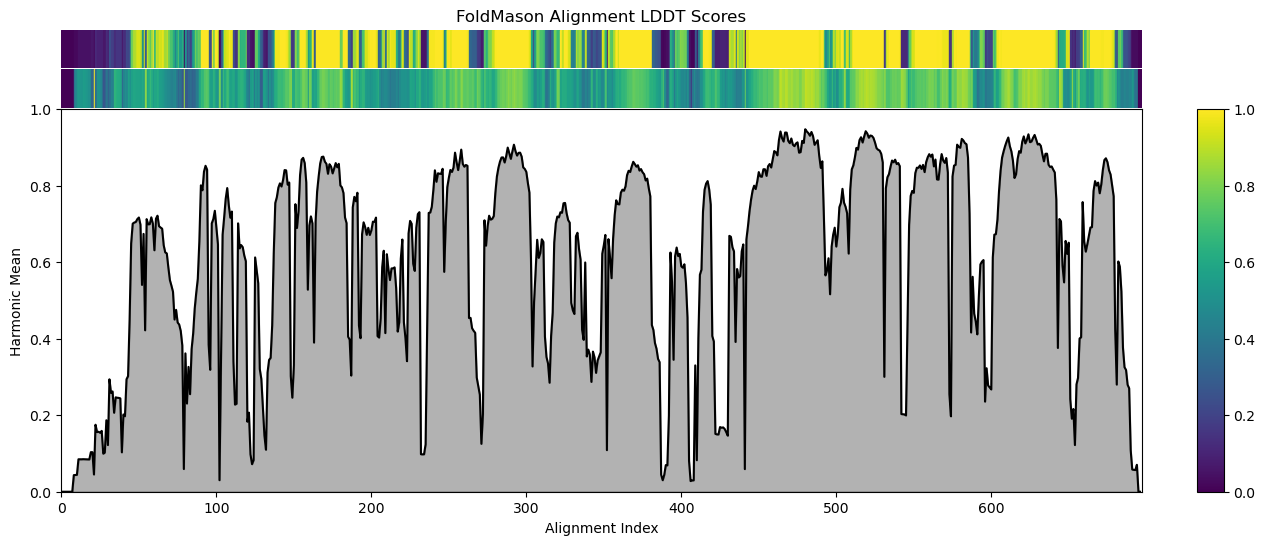

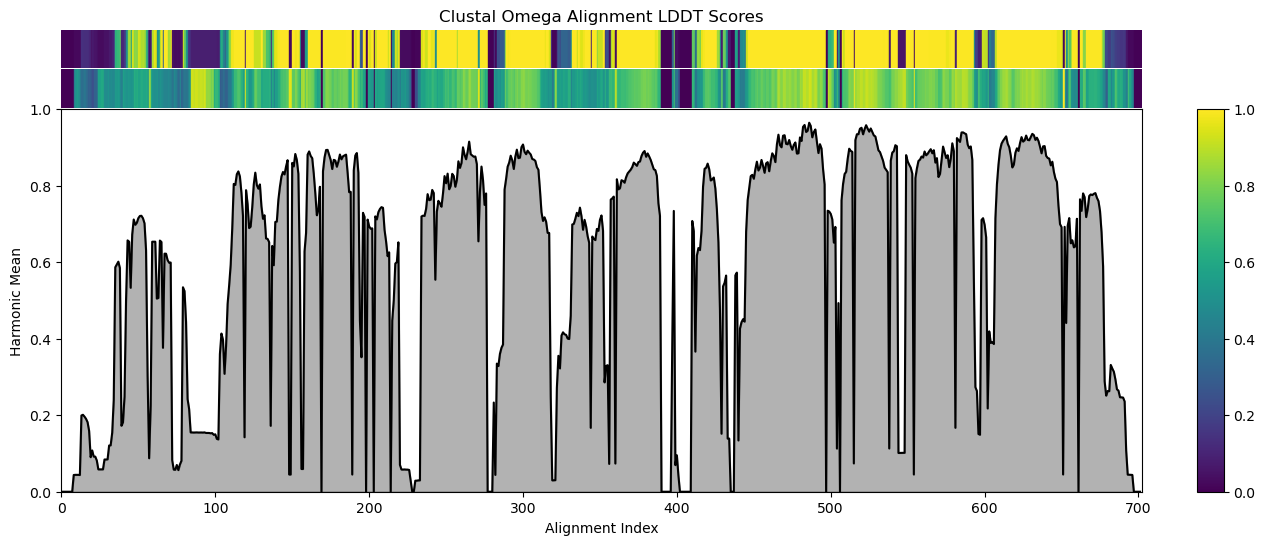

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_foldmason_scores(occupancy, lddt, title="Alignment Scores"):
    """
    Plot FoldMason scores with a color bar and a line plot with filled regions.
    Discontinuous line is plotted where LDDT scores are zero.

    Parameters:
    - foldmason_oc: Array-like, values to map to colors in the color bar.
    - foldmason_lddt: Array-like, LDDT scores to plot.

    Returns:
    - None: Displays the plot.
    """
    # Set up the figure with a 3x2 subplot grid
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 6),
                        gridspec_kw={'height_ratios': [1, 1, 10], 'width_ratios': [40, 1]})


    # Subplots 1 and 2: Empty
    axs[0, 1].axis('off')
    axs[1, 1].axis('off')

    # Subplot 3 (Row 2, Column 1): Occupancy Color Bar Plot
    cmap = plt.cm.viridis
    for i, val in enumerate(occupancy):
        color = cmap(val / max(occupancy))
        rect = patches.Rectangle((i, 0), 1, 1, color=color)
        axs[0, 0].add_patch(rect)

    axs[0, 0].set_xlim(0, len(occupancy))
    axs[0, 0].set_ylim(0, 1)
    axs[0, 0].axis('off')

    # Subplot 4 (Row 2, Column 1): lddt Color Bar Plot
    for i, val in enumerate(lddt):
        color = cmap(val / max(lddt))
        rect = patches.Rectangle((i, 0), 1, 1, color=color)
        axs[1, 0].add_patch(rect)

    axs[1, 0].set_xlim(0, len(lddt))
    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].axis('off')

    # Subplot 5 (Row 3, Column 1): Harmonic Mean Plot
    harmonic_mean = [0 if lddt == 0 or oc == 0 else 2 / ((1/lddt) + (1/oc)) for lddt, oc in zip(lddt, occupancy)]
    axs[2, 0].plot(harmonic_mean, color='black')
    axs[2, 0].fill_between(np.arange(len(harmonic_mean)), harmonic_mean, color='black', alpha=0.3)

    # Adjust the plot limits and labels
    axs[2, 0].set_xlim(0, len(occupancy))
    axs[2, 0].set_ylim(0, 1)
    axs[2, 0].set_xlabel("Alignment Index")
    axs[2, 0].set_ylabel("Harmonic Mean")
    axs[0, 0].set_title(title)

    # Subplot 6 (Row 3, Column 2): Colorbar
    norm = plt.Normalize(vmin=min(occupancy + lddt), vmax=max(occupancy + lddt))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=axs[2, 1])

    # Adjust layout and show plot
    plt.subplots_adjust(hspace=0.01, wspace=0.1)
    plt.show()

# Example usage:
plot_foldmason_scores(foldmason_oc, foldmason_lddt, title = "FoldMason Alignment LDDT Scores")
plot_foldmason_scores(clustal_oc, culstal_lddt, title = "Clustal Omega Alignment LDDT Scores")
